
>>> TF-IDF SOM Training Start <<<

Epoch  1 → QE=0.7237, TE=0.0580
Epoch  2 → QE=0.7155, TE=0.0460
Epoch  3 → QE=0.7096, TE=0.0500
Epoch  4 → QE=0.7153, TE=0.0420
Epoch  5 → QE=0.7311, TE=0.0580
Epoch  6 → QE=0.7198, TE=0.0360
Epoch  7 → QE=0.7040, TE=0.0620
Epoch  8 → QE=0.7178, TE=0.0540
Epoch  9 → QE=0.7154, TE=0.0480
Epoch 10 → QE=0.7193, TE=0.0200
Epoch 11 → QE=0.7210, TE=0.1040
Epoch 12 → QE=0.7300, TE=0.0500
Epoch 13 → QE=0.7324, TE=0.0580
Epoch 14 → QE=0.7170, TE=0.0480
Epoch 15 → QE=0.7185, TE=0.0860
Epoch 16 → QE=0.7141, TE=0.0180
Epoch 17 → QE=0.7003, TE=0.0380
Epoch 18 → QE=0.7180, TE=0.0300
Epoch 19 → QE=0.7153, TE=0.0600
Epoch 20 → QE=0.7249, TE=0.0200
Epoch 21 → QE=0.7259, TE=0.0460
Epoch 22 → QE=0.7173, TE=0.0400
Epoch 23 → QE=0.7280, TE=0.0400
Epoch 24 → QE=0.7121, TE=0.0380
Epoch 25 → QE=0.7069, TE=0.0420
Epoch 26 → QE=0.7050, TE=0.0440
Epoch 27 → QE=0.7086, TE=0.0260
Epoch 28 → QE=0.7206, TE=0.0320
Epoch 29 → QE=0.7232, TE=0.0800
Epoch 30 → QE=0.7154, TE=0.0620
Epoc

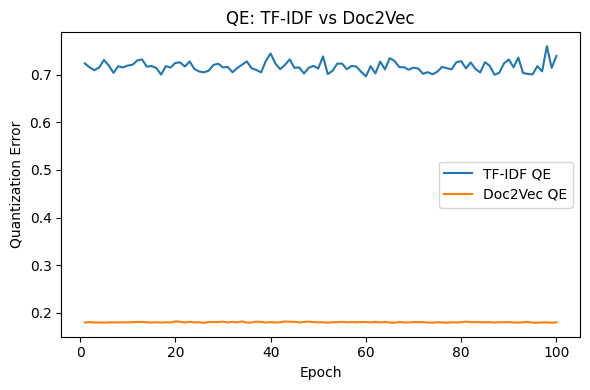

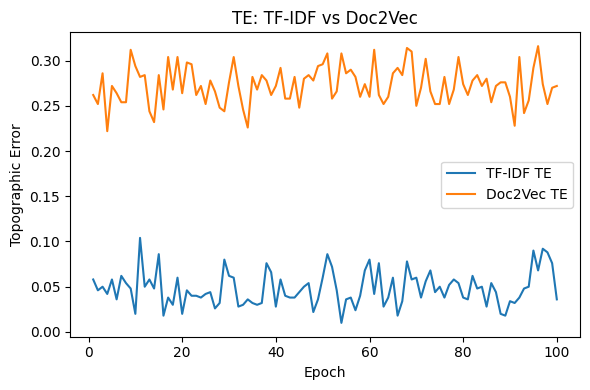

最佳 Epoch → TF-IDF SOM: 60, Doc2Vec SOM: 26


In [ ]:
import numpy as np
import scipy.sparse as sp
from numbasom import SOM
from sklearn.preprocessing import normalize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pickle
import io
import contextlib


with open(r'C:\Users\golds\Desktop\作业julian\random_news_500.txt', encoding='utf-8') as f:
    docs = [line.strip() for line in f if line.strip()]

tfidf = TfidfVectorizer(max_features=2000, min_df=2, stop_words='english')
X_tfidf = tfidf.fit_transform(docs).toarray()

tagged = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(docs)]
d2v = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40, seed=42)
d2v.build_vocab(tagged)
d2v.train(tagged, total_examples=d2v.corpus_count, epochs=d2v.epochs)
X_d2v = np.vstack([d2v.dv[i] for i in range(len(docs))])
X_d2v = normalize(X_d2v, axis=1)


def train_som_with_metrics(X, grid_size=(20,20), epochs=50, label="SOM"):
    som = SOM(som_size=grid_size, is_torus=False)
    qe_list, te_list, snapshots = [], [], []
    gx, gy = grid_size

    print(f"\n>>> {label} Training Start <<<\n")
    for epoch in range(epochs):

        with contextlib.redirect_stdout(io.StringIO()):
            lattice = som.train(X, num_iterations=X.shape[0])
        flat = lattice.reshape(-1, lattice.shape[2])

        # QE
        dists = [np.min(np.linalg.norm(flat - v, axis=1)) for v in X]
        qe = np.mean(dists)
        qe_list.append(qe)

        # TE
        def coords(idx): return divmod(idx, gy)
        te_count = 0
        for v in X:
            d2 = np.sum((flat - v)**2, axis=1)
            winners = np.argsort(d2)[:2]
            c1, c2 = coords(winners[0]), coords(winners[1])
            if abs(c1[0] - c2[0]) + abs(c1[1] - c2[1]) > 1:
                te_count += 1
        te = te_count / len(X)
        te_list.append(te)

        snapshots.append(lattice.copy())


        print(f"Epoch {epoch+1:2d} → QE={qe:.4f}, TE={te:.4f}")
    print(f"\n>>> {label} Training End <<<\n")
    return qe_list, te_list, snapshots

qe_tfidf, te_tfidf, snap_tfidf = train_som_with_metrics(
    X_tfidf, grid_size=(20,20), epochs=100, label="TF-IDF SOM"
)

qe_d2v, te_d2v, snap_d2v = train_som_with_metrics(
    X_d2v, grid_size=(20,20), epochs=100, label="Doc2Vec SOM"
)

epochs = range(1, len(qe_tfidf)+1)
plt.figure(figsize=(6,4))
plt.plot(epochs, qe_tfidf, label='TF-IDF QE')
plt.plot(epochs, qe_d2v,   label='Doc2Vec QE')
plt.xlabel('Epoch'); plt.ylabel('Quantization Error')
plt.title('QE: TF-IDF vs Doc2Vec')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, te_tfidf, label='TF-IDF TE')
plt.plot(epochs, te_d2v,   label='Doc2Vec TE')
plt.xlabel('Epoch'); plt.ylabel('Topographic Error')
plt.title('TE: TF-IDF vs Doc2Vec')
plt.legend(); plt.tight_layout(); plt.show()

best_tfidf = int(np.argmin(qe_tfidf))
best_d2v   = int(np.argmin(qe_d2v))

pickle.dump(snap_tfidf[best_tfidf], open('som_tfidf_best.pkl','wb'))
pickle.dump(snap_d2v[best_d2v],     open('som_d2v_best.pkl','wb'))

print(f"最佳 Epoch → TF-IDF SOM: {best_tfidf+1}, Doc2Vec SOM: {best_d2v+1}")


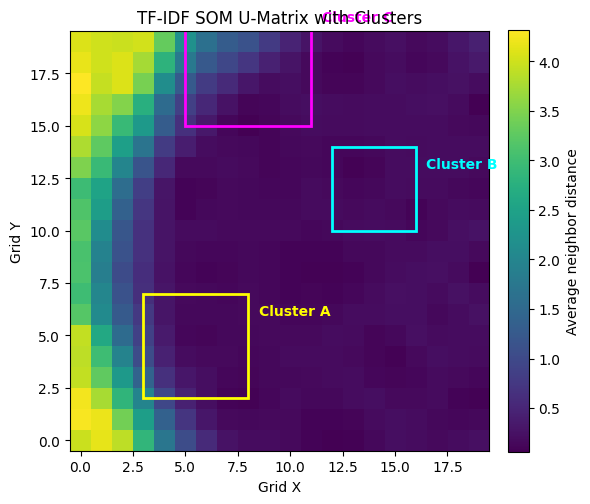

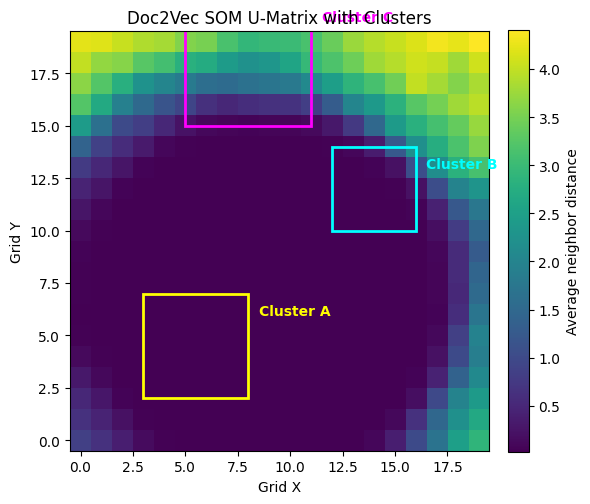

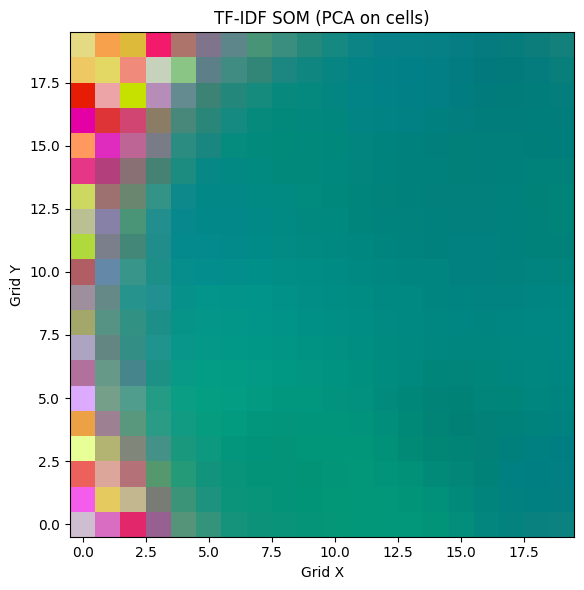

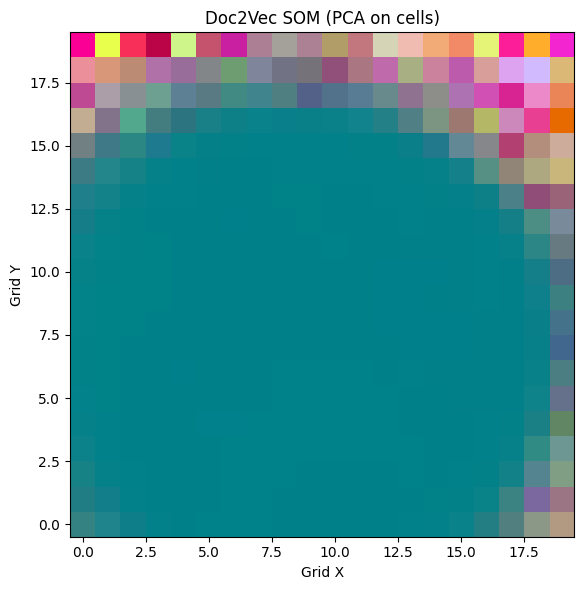

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37807471063301046..1.6345394971507932].


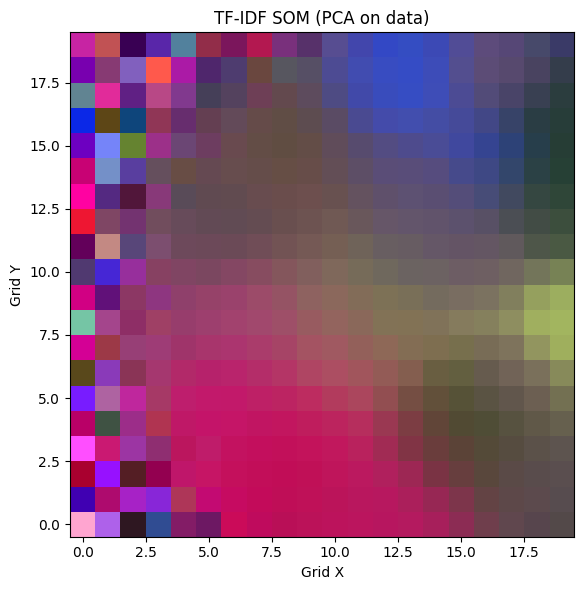

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3427861528040133..2.122385107510068].


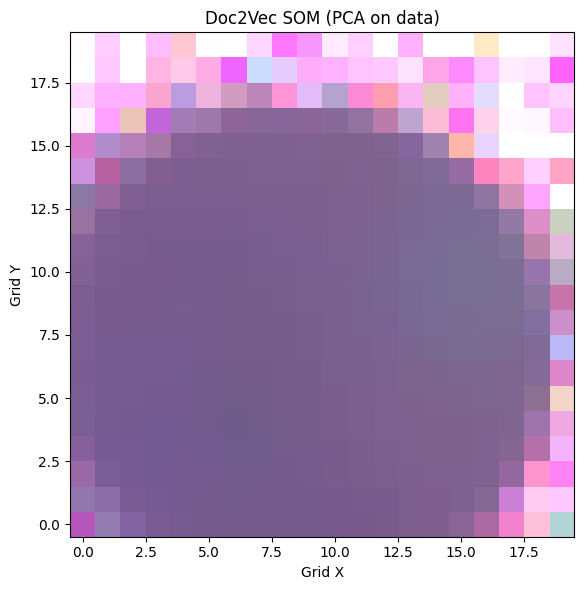

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

with open(r'C:\Users\golds\Desktop\Vectorial Encodings\random_news_500.txt', encoding='utf-8') as f:
    docs = [line.strip() for line in f if line.strip()]

tfidf = TfidfVectorizer(max_features=2000, min_df=2, stop_words='english')
X_tfidf = tfidf.fit_transform(docs).toarray()

tagged = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(docs)]
d2v = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=100, seed=42)
d2v.build_vocab(tagged)
d2v.train(tagged, total_examples=d2v.corpus_count, epochs=d2v.epochs)
X_d2v = np.vstack([d2v.dv[i] for i in range(len(docs))])
X_d2v = normalize(X_d2v, axis=1)

w_tfidf = pickle.load(open(r'C:\Users\golds\Desktop\Vectorial Encodings\som_tfidf_best.pkl', 'rb'))
w_d2v   = pickle.load(open(r'C:\Users\golds\Desktop\Vectorial Encodings\som_d2v_best.pkl',   'rb'))

def compute_u(weights):
    gx, gy, _ = weights.shape
    u = np.zeros((gx, gy))
    for i in range(gx):
        for j in range(gy):
            neigh = []
            for ni, nj in [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]:
                if 0 <= ni < gx and 0 <= nj < gy:
                    neigh.append(np.linalg.norm(weights[i,j] - weights[ni,nj]))
            u[i,j] = np.mean(neigh)
    return u

u_tfidf = compute_u(w_tfidf)
u_d2v   = compute_u(w_d2v)

cluster_regions = [
    (2, 3, 5, 5, 'Cluster A', 'yellow'),
    (10,12,4,4,'Cluster B','cyan'),
    (15, 5,6,6,'Cluster C','magenta'),
]

def plot_u_matrix(u, regions, title):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(u, origin='lower', cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Grid X'); ax.set_ylabel('Grid Y')
    for (r, c, h, w, lbl, col) in regions:
        rect = Rectangle((c, r), w, h, fill=False, edgecolor=col, linewidth=2)
        ax.add_patch(rect)
        ax.text(c+w+0.5, r+h-0.5, lbl, color=col,
                fontsize=10, weight='bold', va='top', ha='left')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Average neighbor distance')
    plt.tight_layout()
    plt.show()

plot_u_matrix(u_tfidf, cluster_regions, 'TF-IDF SOM U-Matrix with Clusters')
plot_u_matrix(u_d2v,   cluster_regions, 'Doc2Vec SOM U-Matrix with Clusters')

def plot_pca_rgb_cells(weights, title):
    gx, gy, dim = weights.shape
    flat = weights.reshape(-1, dim)
    pca = PCA(n_components=3).fit(flat)
    comps = pca.transform(flat)

    mins, maxs = comps.min(0), comps.max(0)
    rgb = (comps - mins) / (maxs - mins)
    img = rgb.reshape(gx, gy, 3)
    plt.figure(figsize=(6,6))
    plt.imshow(img, origin='lower')
    plt.title(title + ' (PCA on cells)')
    plt.xlabel('Grid X'); plt.ylabel('Grid Y')
    plt.tight_layout()
    plt.show()

plot_pca_rgb_cells(w_tfidf, 'TF-IDF SOM')
plot_pca_rgb_cells(w_d2v,   'Doc2Vec SOM')

def plot_pca_rgb_data(weights, data, title):
    gx, gy, dim = weights.shape
    pca = PCA(n_components=3).fit(data)
    flat = weights.reshape(-1, dim)
    comps = pca.transform(flat)
    mins, maxs = data.min(0), data.max(0)
    # Use data PCA normalization range
    data_comps = pca.transform(data)
    dmins, dmaxs = data_comps.min(0), data_comps.max(0)
    rgb = (comps - dmins) / (dmaxs - dmins)
    img = rgb.reshape(gx, gy, 3)
    plt.figure(figsize=(6,6))
    plt.imshow(img, origin='lower')
    plt.title(title + ' (PCA on data)')
    plt.xlabel('Grid X'); plt.ylabel('Grid Y')
    plt.tight_layout()
    plt.show()

plot_pca_rgb_data(w_tfidf, X_tfidf, 'TF-IDF SOM')
plot_pca_rgb_data(w_d2v,   X_d2v,   'Doc2Vec SOM')
